# Introduction

## Install and import packages

In [ ]:
import pkg_resources
import pip
installedPackages = {pkg.key for pkg in pkg_resources.working_set}
required = { 'pandas','numpy', 'matplotlib', 'seaborn','toad','pickle','sklearn', 'xlrd','module_name'}
missing = required - installedPackages
if missing:
    !pip install pandas
    !pip install numpy
    !pip install matplotlib
    !pip install seaborn
    !pip install toad
    !pip install pickle
    !pip install sklearn
    !pip install xlrd
    !pip install module_name

import pandas as pd
from sklearn.metrics import roc_auc_score,roc_curve,auc,precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
import time
import numpy as np
import glob
import math
import seaborn as sns 
import matplotlib.pyplot as plt
import toad
import pickle

## Load data and check the default label rate

In [3]:
# use pandas to load the csv file
data = pd.read_excel('UCI_Credit_Card.xls', header=1)
# check the size of the data
data.shape
# check few lines
display(data.head())
# use the world 'label'
data['label']=data['default payment next month']
data=data.drop(columns=['default payment next month'])


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [6]:
#check the fraud proportion of the data
# target_info(data['label'])
# set an exclude list for the scorecard package Toad
exclude_list = ['ID','label']


In [7]:
data.ID.describe()

count    30000.000000
mean     15000.500000
std       8660.398374
min          1.000000
25%       7500.750000
50%      15000.500000
75%      22500.250000
max      30000.000000
Name: ID, dtype: float64

In [8]:
# use the ID column to split the train-test data
# train = data_split(data,start = 0, end=22500,date_col='ID')
# test = data_split(data,start = 22500, end=172792,date_col='ID')

In [9]:
data.iloc[:, :-1].shape, data.iloc[:,-1].shape

((30000, 24), (30000,))

In [10]:
train, test = train_test_split(data, test_size=0.2)
train.shape, test.shape

((24000, 25), (6000, 25))

## Feature Filtering

In [11]:
###feature filtering by missing value, IV & corrrelation：
##If the missing value rate is greater than the threshold, delete the feature
##If the correlation coefficient is greater than the threshold, delete the feature
##If the IV is smaller than the threshold, delete the features

train_selected, drop_lst= toad.selection.select(frame = train,
                                                target=train['label'], 
                                                empty = 0.7, 
                                                iv = 0.02, corr = 1, 
                                                return_drop=True, 
                                                exclude=exclude_list)
print("keep:",train_selected.shape[1],
      "drop empty:",len(drop_lst['empty']),
      "drop iv:",len(drop_lst['iv']),
      "drop corr:",len(drop_lst['corr']))

keep: 23 drop empty: 0 drop iv: 2 drop corr: 0


In [12]:
drop_lst

{'empty': array([], dtype=float64),
 'iv': array(['SEX', 'MARRIAGE'], dtype=object),
 'corr': array([], dtype=object)}

In [13]:
# output the iv table to a dataframe
def output_iv_importance(train_selected,label_col):
    feat_import_iv = toad.quality(train_selected,label_col,iv_only=True)
    feat_import_iv=feat_import_iv['iv']
    feat_import_iv = feat_import_iv.reset_index()
    feat_import_iv.columns = ['name','iv']
    return feat_import_iv

df_iv=output_iv_importance(train_selected,'label')
df_iv.head(5)

,name,iv
0,PAY_0,0.874086
1,PAY_2,0.540867
2,PAY_3,0.403730
3,PAY_4,0.356729
4,PAY_5,0.338254


## Feature Binning

In [14]:
%%time
# import time
# start = time.time()
combiner = toad.transform.Combiner()
# use the filtered features for training
# Use the stable chi-square binning, 
# specifying that each bin has at least 5% data to ensure stability
# empty values ​​will be automatically assigned to the best bin
combiner.fit(X=train_selected,
             y=train_selected['label'],
             method='chi',
             min_samples = 0.05,
             exclude=exclude_list)
# end = time.time()
# print((end-start)/60)

#output binning
bins = combiner.export()

CPU times: total: 1min 59s
Wall time: 1min 59s


In [15]:
bins

{'LIMIT_BAL': [50000, 80000, 150000, 270000, 370000],
 'EDUCATION': [2],
 'AGE': [26, 36, 46],
 'PAY_0': [-1, 0, 1, 2],
 'PAY_2': [-1, 2],
 'PAY_3': [-1, 0, 2],
 'PAY_4': [-1, 0, 1],
 'PAY_5': [-1, 0, 2],
 'PAY_6': [-1, 0, 2],
 'BILL_AMT1': [2501],
 'BILL_AMT2': [2392, 10006, 35028],
 'BILL_AMT3': [2395, 7859, 69248],
 'BILL_AMT4': [2501],
 'BILL_AMT5': [2503, 12036, 48105],
 'BILL_AMT6': [2395, 10950, 34755],
 'PAY_AMT1': [22, 2001, 4555, 16918],
 'PAY_AMT2': [82, 1601, 4550, 15002],
 'PAY_AMT3': [1, 2929, 4502],
 'PAY_AMT4': [1, 1495, 2851, 5330],
 'PAY_AMT5': [1, 1101, 2930, 10000],
 'PAY_AMT6': [1, 1503, 4059, 9800]}

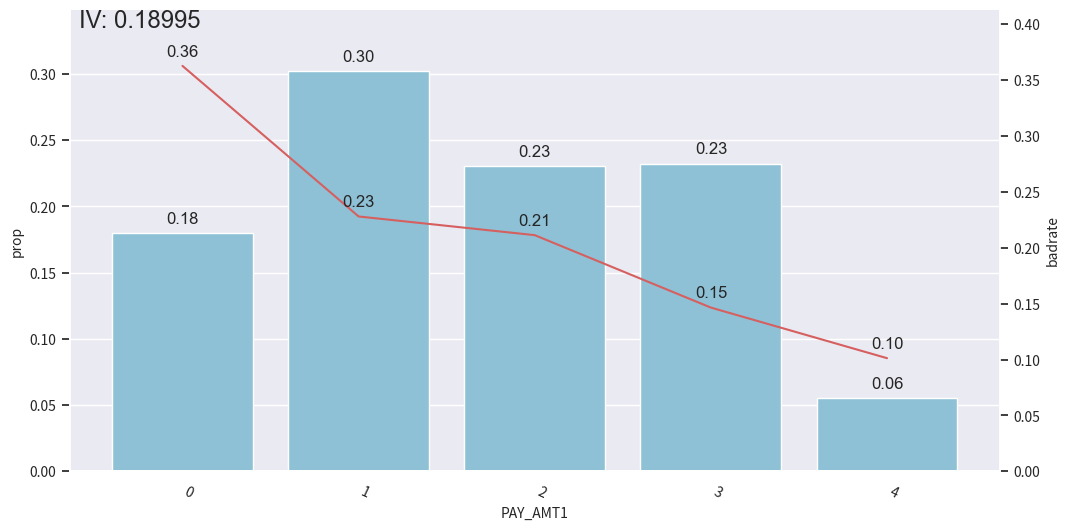

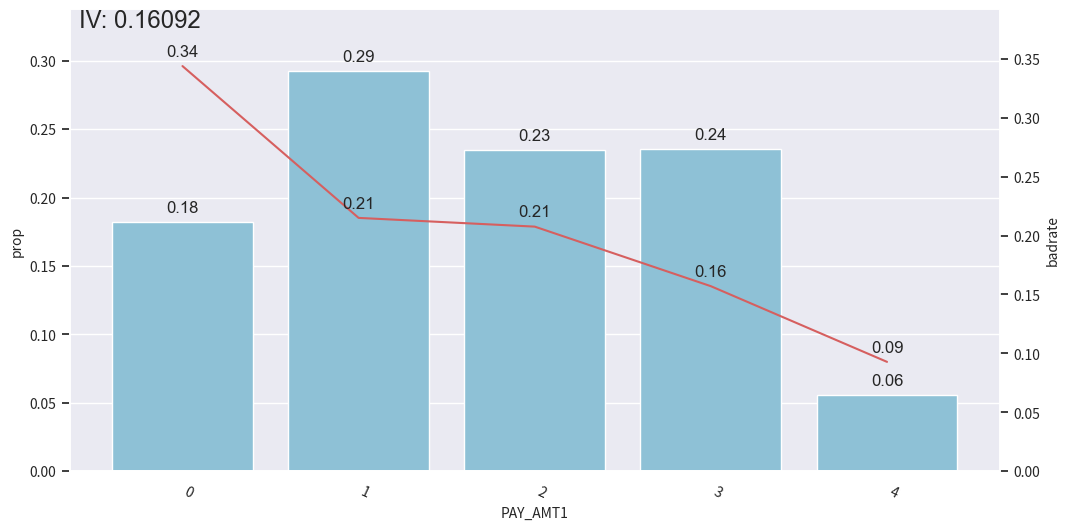

In [16]:
#apply binning
# plt.figure(figsize=(10,12))
train_selected_bin = combiner.transform(train_selected)
test_bin = combiner.transform(test[train_selected_bin.columns])

#Fine tune bins
from toad.plot import  bin_plot,badrate_plot
bin_plot(train_selected_bin,x='PAY_AMT1',target='label')
bin_plot(test_bin,x='PAY_AMT1',target='label')
plt.show()
# plt.tight_layout()

## Transform to WOE and Calculate PSI

In [17]:
##transform to WOE
t=toad.transform.WOETransformer()
#transform training set
train_woe = t.fit_transform(X=train_selected_bin,
                            y=train_selected_bin['label'], 
                            exclude=exclude_list)
#transform testing set
test_woe = t.transform(test_bin)

final_data_woe = pd.concat([train_woe,test_woe])

In [18]:
final_data_woe

,ID,LIMIT_BAL,EDUCATION,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,label
25163,25164,0.271727,0.095413,-0.018843,-0.658678,-0.404635,-0.284076,-0.230096,-0.202853,-0.196774,...,-0.019962,0.144841,0.181844,-0.065782,-0.041762,0.033009,-0.319857,0.009187,-0.067550,0
28715,28716,-0.733046,0.095413,-0.018843,-0.605430,-0.213840,-0.189305,-0.158756,-0.135593,-0.115379,...,-0.019962,-0.105254,-0.073418,-0.932471,-1.210205,-0.522232,-0.536315,-0.758663,-0.747414,0
19494,19495,-0.316154,-0.189874,-0.144212,-0.336246,-0.404635,-0.453102,-0.415230,-0.389388,-0.321191,...,0.056859,0.053570,-0.009745,-0.065782,-0.041762,0.033009,0.469581,0.009187,0.361821,0
8059,8060,0.077389,0.095413,-0.144212,-0.605430,-0.213840,-0.189305,-0.158756,-0.135593,-0.115379,...,-0.019962,0.053570,-0.009745,-0.932471,0.100836,-0.522232,0.469581,0.389871,0.361821,0
19738,19739,0.271727,0.095413,-0.018843,-0.658678,-0.404635,-0.284076,-0.230096,-0.202853,-0.196774,...,-0.019962,0.144841,0.181844,0.031758,-0.041762,0.033009,0.052238,0.009187,0.119874,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1539,1540,0.077389,0.095413,-0.144212,-0.658678,-0.404635,1.333783,1.379595,-0.202853,-0.196774,...,-0.019962,-0.105254,-0.073418,-0.065782,-0.410514,0.033009,-0.319857,-0.242971,-0.067550,0
22073,22074,-0.733046,0.095413,-0.144212,-0.658678,-0.404635,-0.453102,-0.415230,-0.202853,-0.321191,...,-0.019962,-0.237721,-0.009745,-0.932471,0.100836,-0.522232,0.469581,0.076447,0.119874,0
28532,28533,0.271727,0.095413,-0.018843,0.602862,1.486237,1.333783,1.379595,1.466869,1.314372,...,-0.019962,0.144841,0.181844,-0.065782,0.100836,0.033009,0.469581,0.389871,0.361821,1
18763,18764,-0.316154,-0.189874,-0.144212,-0.336246,-0.404635,-0.453102,-0.415230,-0.389388,-0.196774,...,0.056859,0.053570,-0.009745,0.031758,0.100836,0.033009,0.052238,0.389871,0.119874,0


## Calculate PSI

In [19]:
#get the feature name
features_list = [feat for feat in train_woe.columns if feat not in exclude_list]
#calculate PSI using toad
psi_df = toad.metrics.PSI(train_woe[features_list], test_woe[features_list]).sort_values()
#put into a dataframe
psi_df = psi_df.reset_index()
psi_df = psi_df.rename(columns = {'index' : 'feature',0:'psi'})

# features less than 0.25
psi005 = list(psi_df[psi_df.psi<0.25].feature)
# features geater than 0.25
psi_remove = list(psi_df[psi_df.psi>=0.25].feature)

# keep exclude list
for i in exclude_list:
    if i in psi005:
        pass
    else:
        psi005.append(i) 
# remove features that are geater than 0.25
train_selected_woe_psi = train_woe[psi005]
off_woe_psi = test_woe[psi005]

# output our final data table
final_data_woe = pd.concat([train_selected_woe_psi,off_woe_psi])
psi_df

,feature,psi
0,EDUCATION,0.000063
1,BILL_AMT4,0.000170
2,PAY_AMT4,0.000190
3,LIMIT_BAL,0.000226
4,AGE,0.000256
5,PAY_AMT5,0.000319
6,PAY_AMT1,0.000463
7,BILL_AMT2,0.000569
8,PAY_AMT2,0.000622
9,PAY_6,0.000629


## Output Final IV

In [20]:
# output the IV
features_use = [feat for feat in final_data_woe.columns if feat not in exclude_list]
print(len(features_use))

df_iv=output_iv_importance(final_data_woe[features_use+['label']],'label')
df_iv

21


,name,iv
0,PAY_0,0.873565
1,PAY_2,0.546857
2,PAY_3,0.412420
3,PAY_4,0.359289
4,PAY_5,0.333734
5,PAY_6,0.285164
6,PAY_AMT1,0.183588
7,LIMIT_BAL,0.180655
8,PAY_AMT2,0.162939
9,PAY_AMT3,0.123238


## Model Tuning

### Logistic Regression

In [25]:
def check_train_test_auc(x_train,y_train,x_test,y_test):
    from sklearn.linear_model import LogisticRegression
    lr = LogisticRegression(random_state=42,C= 0.1, penalty='l2', solver='newton-cg')

  
    lr = LogisticRegression(class_weight='balanced')
    lr.fit(x_train, y_train)

    pred_train = lr.predict_proba(x_train)[:,1]
    from toad.metrics import KS, AUC

    print('train KS',KS(pred_train, y_train))
    print('train AUC',AUC(pred_train, y_train))
    
    pred_OOT =lr.predict_proba(x_test)[:,1]
    print('Test KS',KS(pred_OOT, y_test))
    print('Test AUC',AUC(pred_OOT, y_test))
    
   

    # fig, ax = plt.subplots(figsize=(12, 8))
    # plot_roc_curve(lr, x_test, y_test, color='blue', ax=ax)

#train & test
check_train_test_auc(x_train = train_woe[features_use],y_train=train_woe['label'], x_test =test_woe[features_use] ,y_test = test_woe['label'])
         

train KS 0.4141281055482698
train AUC 0.7734170629628533
Test KS 0.4215224751143113
Test AUC 0.7745702270782721


### Train a GradientBoostingClassifier 

True Positive： 502
True Negative： 4456
False Positive： 247
False Negative： 795
accuracy:  0.8263333333333334
（recall）:  0.38704703161141096
（precision）:  0.6702269692923899
F1 score:  0.49071358748778104
              precision    recall  f1-score   support

           0       0.85      0.95      0.90      4703
           1       0.67      0.39      0.49      1297

    accuracy                           0.83      6000
   macro avg       0.76      0.67      0.69      6000
weighted avg       0.81      0.83      0.81      6000

balanced_accuracy_score:  0.6672636816572896


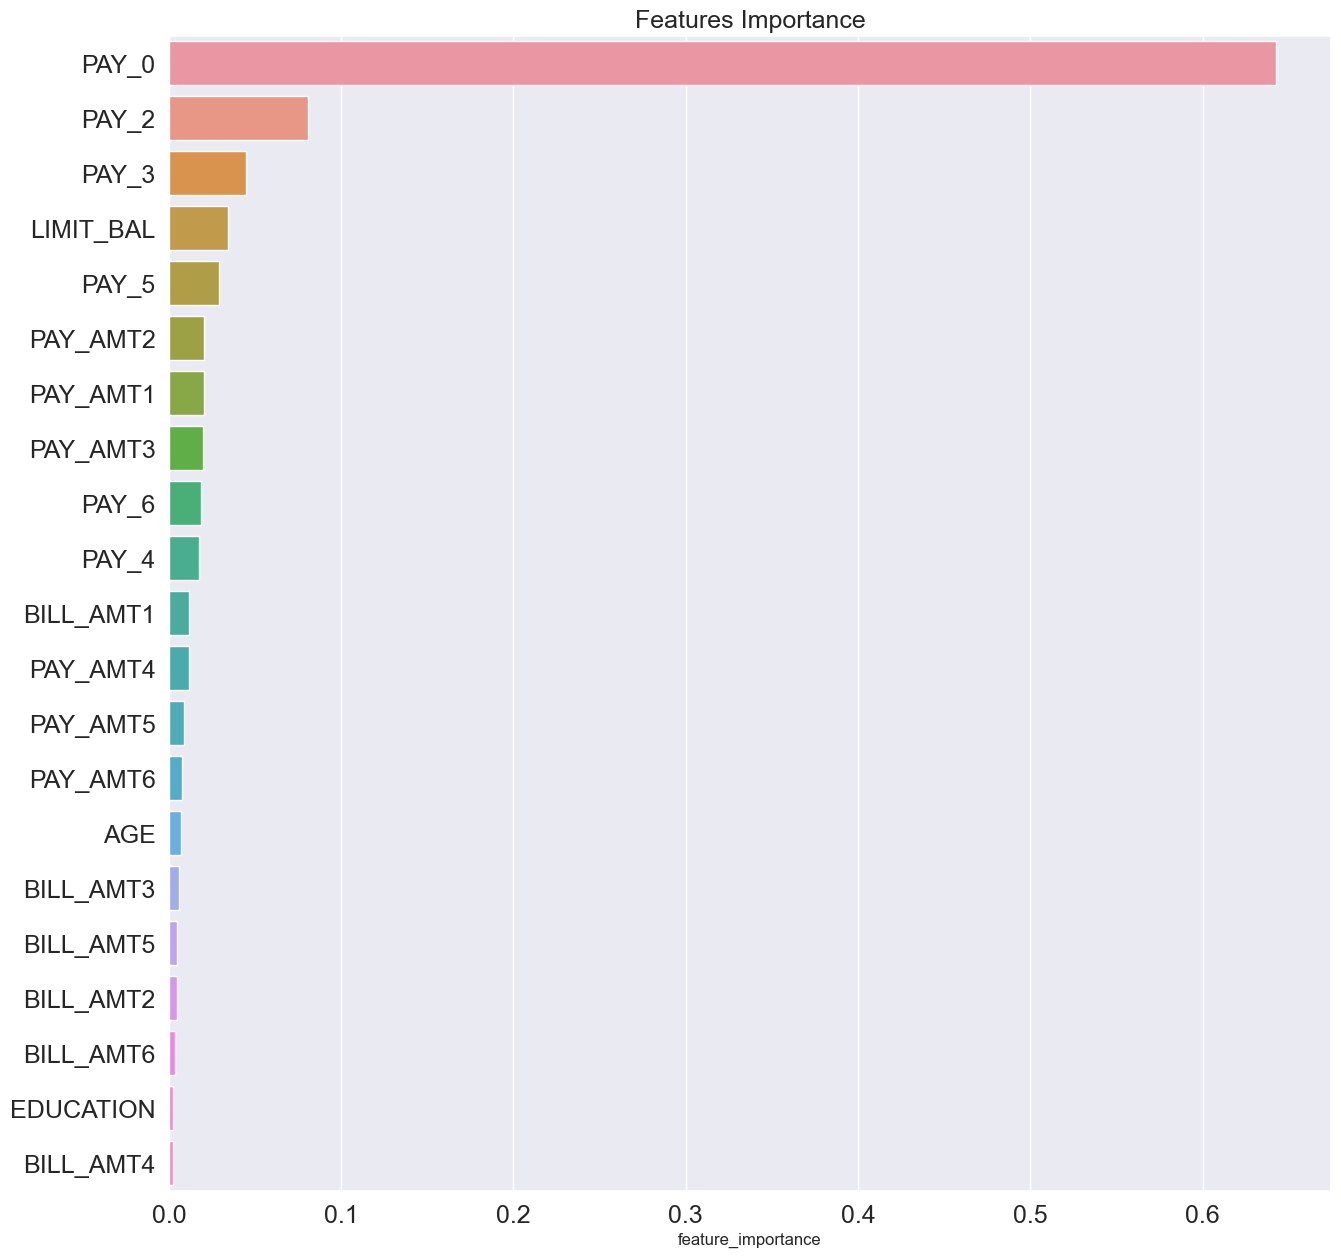

In [26]:
def get_evaluation_scores(label, predictions):
    from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
    from sklearn.metrics import balanced_accuracy_score
    tp, fn, fp, tn = confusion_matrix(label,predictions,labels=[1,0]).reshape(-1)
    print('True Positive：',tp)
    print('True Negative：',tn)
    print('False Positive：',fp)
    print('False Negative：',fn)
    accuracy = (tp+tn)/(tp+fn+fp+tn)
    print('accuracy: ',accuracy)
    recall = tp/(tp+fn)
    print('（recall）: ',recall)
    precision = tp/(tp+fp)
    print('（precision）: ',precision)
    #f1 score = 2*(P*R)/(P+R)
    f1 = 2*precision*recall/(precision+recall)
    print('F1 score: ',f1)
    
    print(classification_report(label, predictions))
    
    print('balanced_accuracy_score: ',balanced_accuracy_score(label,predictions))
    return precision, recall

def evaluate_result(df_train,df_test,features_name):
    from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
    import seaborn as sns
    import matplotlib.pyplot as plt
    start = time.time()
    x_train = df_train[features_name]
    y_train = df_train['label']

    x_test  = df_test[features_name]
    y_test  = df_test['label']

    model = GradientBoostingClassifier(n_estimators=250,random_state=0)
    model.fit(x_train,y_train)
    predictions = model.predict(x_test)
    get_evaluation_scores(label = y_test, predictions=predictions)
    feat_importances = pd.Series(model.feature_importances_, index=features_name)
    feat_importances=pd.DataFrame(feat_importances).reset_index()
    feat_importances.columns=['feature_name','feature_importance']
    feat_importances=feat_importances.sort_values(['feature_importance'],ascending=False)
    import matplotlib.pyplot as plt
    plt.figure(figsize=(15,15))

    sns_plot1=sns.barplot(x=feat_importances.feature_importance, y=feat_importances.feature_name,estimator=sum)
    plt.title("Features Importance",size=18)
    plt.ylabel('', size = 15)
    plt.tick_params(labelsize=18)
    return feat_importances,model,x_train,y_train,x_test,y_test

fet_importance_GBDT_reason,model,x_train,y_train,x_test,y_test = evaluate_result(df_train=train_woe,
                df_test=test_woe,
                features_name=features_use)

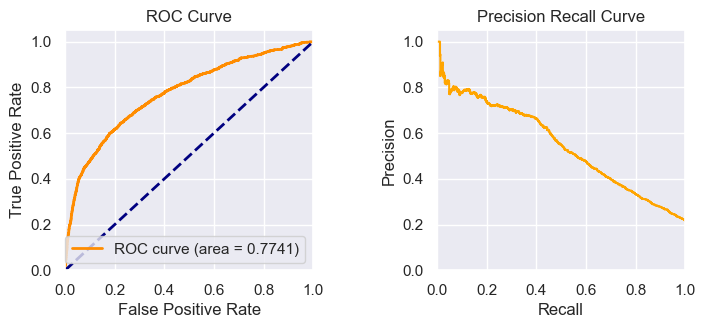

CPU times: total: 234 ms
Wall time: 253 ms


In [27]:
%%time
def plot_roc_pre_recall_curve(labels, probs):
    from sklearn.metrics import precision_recall_curve
    # Get ROC curve FPR and TPR from true labels vs score values
    fpr, tpr, _ = roc_curve(labels, probs)

    # Calculate ROC Area Under the Curve (AUC) from FPR and TPR data points
    roc_auc = auc(fpr, tpr)

    # Calculate precision and recall from true labels vs score values
    precision, recall, _ = precision_recall_curve(labels, probs)

    plt.figure(figsize=(8, 3))

    plt.subplot(1,2,1)
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.4f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.grid(True)

    plt.subplot(1,2,2)
    plt.step(recall, precision, color='orange', where='post')
    # plt.fill_between(recall, precision, step='post', alpha=0.5, color='orange')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision Recall Curve')
    plt.grid(True)

    left  = 0.125  # the left side of the subplots of the figure
    right = 0.9    # the right side of the subplots of the figure
    bottom = 0.1   # the bottom of the subplots of the figure 
    top = 0.9      # the top of the subplots of the figure
    wspace = 0.5   # the amount of width reserved for blank space between subplots
    hspace = 0.2   # the amount of height reserved for white space between subplots
    plt.subplots_adjust(left, bottom, right, top, wspace, hspace)
    plt.show()

probs = model.predict_proba(x_test)[:,1]
sns.set(font_scale = 1)
plot_roc_pre_recall_curve(y_test, probs)

## Model Production

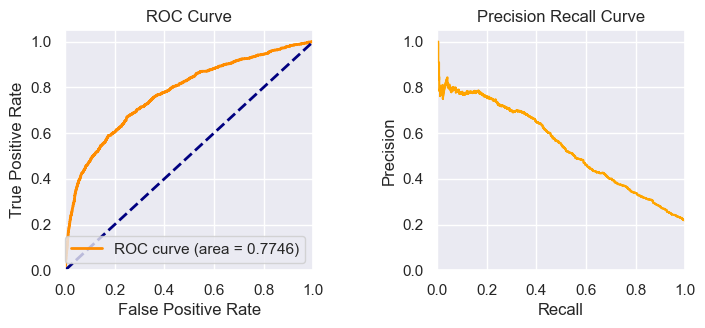

In [28]:
# Let’s train our production model for Logistic Regression
#prepare train & test data
x_train = train_woe[features_use]
y_train=train_woe['label']
x_test =test_woe[features_use] 
y_test = test_woe['label']

#Train LR
#lr = LogisticRegression(random_state=42,C= 0.1, penalty='l2', solver='newton-cg')
lr = LogisticRegression(class_weight = 'balanced')
lr.fit(x_train, y_train)

#check AUC
probs = lr.predict_proba(x_test)[:,1]
sns.set(font_scale = 1)
plot_roc_pre_recall_curve(y_test, probs)


## Scorecard Tuning

In [29]:
%%time
# scorecard tuning
card = toad.ScoreCard(
    combiner = combiner,
    transer = t,
    class_weight = 'balanced',
    C=0.1,
    base_score = 1000,
    base_odds = 35 ,
    pdo = 80,
    rate = 2
)

card.fit(train_woe[features_use], train_woe['label'])

#inference on test data
test['CreditScore'] = card.predict(test)
test['CreditScore'].describe()



CPU times: total: 109 ms
Wall time: 83.6 ms


count    6000.000000
mean      614.678352
std       120.653648
min       150.876926
25%       570.510856
50%       650.803327
75%       694.982014
max       810.969793
Name: CreditScore, dtype: float64

In [30]:
#output the scorecard
final_card_score=card.export()
print(len(final_card_score))

#transform the scorecard into dataframe and save to csv
keys = list(card.export().keys())
score_card_df = pd.DataFrame()
for n in keys:
    temp = pd.DataFrame.from_dict(final_card_score[n], orient='index')
    temp = temp.reset_index()
    temp.columns= ['binning','score']
    temp['variable'] = n
    temp = temp[['variable','binning','score']]
    # score_card_df=score_card_df.append(temp)
    score_card_df = pd.concat([score_card_df, temp], ignore_index=True)

score_card_df.head(30)

21


,variable,binning,score
0,EDUCATION,[-inf ~ 2),30.95
1,EDUCATION,[2 ~ inf),26.58
2,BILL_AMT4,[-inf ~ 2501),27.99
3,BILL_AMT4,[2501 ~ inf),28.06
4,PAY_AMT4,[-inf ~ 1),20.63
5,PAY_AMT4,[1 ~ 1495),27.21
6,PAY_AMT4,[1495 ~ 2851),27.67
7,PAY_AMT4,[2851 ~ 5330),33.08
8,PAY_AMT4,[5330 ~ inf),36.50
9,LIMIT_BAL,[-inf ~ 50000),-9.65


## Distribution Analysis

In [31]:
data
score_card_df

,variable,binning,score
0,EDUCATION,[-inf ~ 2),30.95
1,EDUCATION,[2 ~ inf),26.58
2,BILL_AMT4,[-inf ~ 2501),27.99
3,BILL_AMT4,[2501 ~ inf),28.06
4,PAY_AMT4,[-inf ~ 1),20.63
...,...,...,...
80,PAY_AMT6,[-inf ~ 1),23.90
81,PAY_AMT6,[1 ~ 1503),26.67
82,PAY_AMT6,[1503 ~ 4059),28.81
83,PAY_AMT6,[4059 ~ 9800),32.60


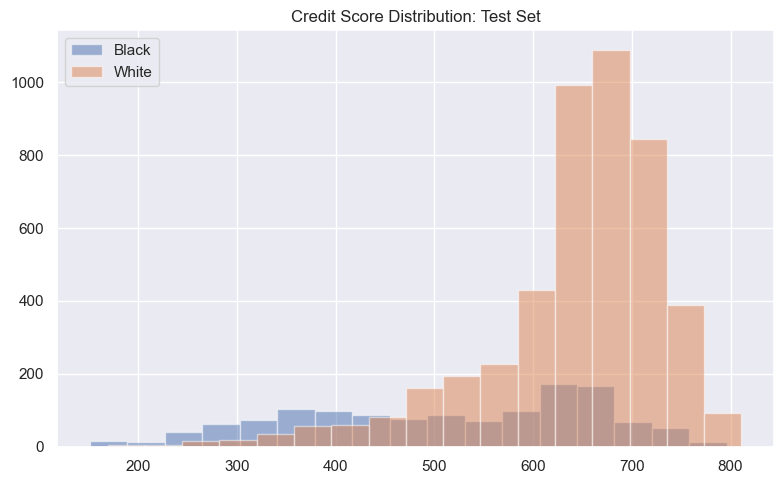

In [32]:
plt.figure(figsize=(8,5))
import random
import numpy
from matplotlib import pyplot as plt

w = 40
n = math.ceil((test['CreditScore'].max() - test['CreditScore'].min())/w)
#bins = numpy.linspace(-10, 10, 100)

plt.hist(test[test.label==1].CreditScore, alpha=0.5, label='Black',bins = n)
plt.hist(test[test.label==0].CreditScore, alpha=0.5, label='White',bins = n)
plt.legend(loc='upper left')
plt.title('Credit Score Distribution: Test Set')
plt.tight_layout()
plt.show()

## Threshold Tuning

In [33]:
test

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,label,CreditScore
4405,4406,360000,1,2,2,28,-1,-1,-1,-1,...,8781,11846,6712,11244,9747,8806,11872,19035,0,753.552463
21747,21748,130000,2,1,1,23,1,2,-1,-1,...,15352,10452,239,29615,22135,15352,10452,4623,0,624.343953
11936,11937,50000,2,2,1,49,-1,-1,0,0,...,1352,20791,25368,1237,457,1354,20794,540,0,665.891746
24248,24249,90000,1,1,2,31,1,2,2,0,...,35504,36249,1600,0,1563,1300,1300,1438,1,515.422223
23230,23231,380000,2,1,2,33,-2,-2,-2,-2,...,6580,6080,16615,3273,9833,6580,6080,4697,0,747.296933
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1539,1540,110000,2,3,2,28,0,0,2,2,...,80006,80421,4000,6000,12,3100,3200,3000,0,611.821203
22073,22074,400000,2,2,2,29,0,-1,-1,-1,...,4568,500,55544,994,5030,0,500,150,0,747.432624
28532,28533,50000,2,3,1,44,1,2,3,2,...,16341,15798,2100,1000,2300,0,0,0,1,395.118240
18763,18764,210000,2,1,2,30,-1,-1,-1,-1,...,980,590,390,390,390,980,0,1288,0,657.021254


In [34]:
test['CreditScore']

4405     753.552463
21747    624.343953
11936    665.891746
24248    515.422223
23230    747.296933
            ...    
1539     611.821203
22073    747.432624
28532    395.118240
18763    657.021254
4394     725.088154
Name: CreditScore, Length: 6000, dtype: float64

In [35]:
test['CreditScore'].iloc[0]

753.5524633903082

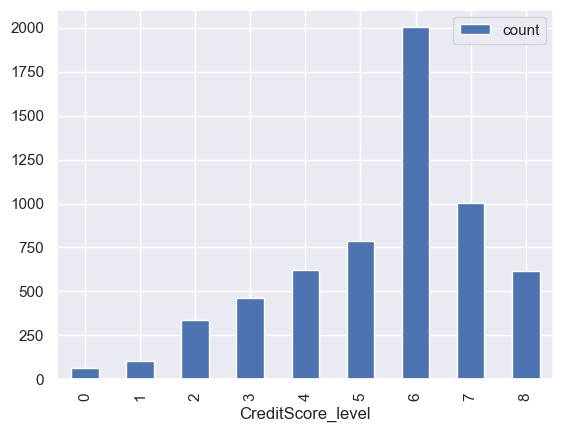

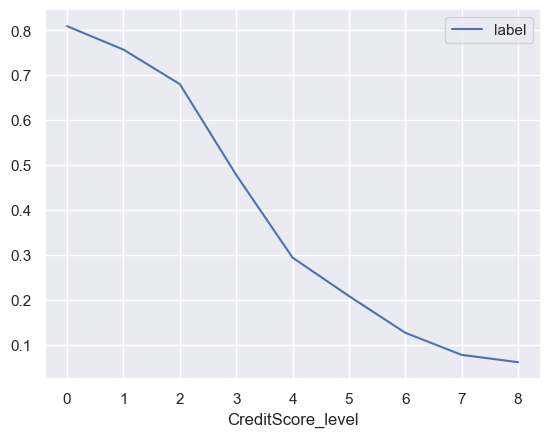

In [36]:
def get_credit_level(
    test,
    target_score='CreditScore',
    out_col='order_level',
    left_bound=-100,
    level_0=100,
    level_1=200,
    level_2=250,
    level_3=300,
    level_4=350,
    level_5=400,
    level_6=450,
    level_7=500,
    level_8=800):
    
    level = []
    for i in range(len(test)):
        score = test[target_score].iloc[i]  # Accessing the value using .iloc[i]
        
        if (score > left_bound) & (score <= level_0):
            level.append(0)
        elif (score > level_0) & (score <= level_1):
            level.append(1)
        elif (score > level_1) & (score <= level_2):
            level.append(2)
        elif (score > level_2) & (score <= level_3):
            level.append(3)
        elif (score > level_3) & (score <= level_4):
            level.append(4)
        elif (score > level_4) & (score <= level_5):
            level.append(5)
        elif (score > level_5) & (score <= level_6):
            level.append(6)
        elif (score > level_6) & (score <= level_7):
            level.append(7)
        elif (score > level_7) & (score <= level_8):
            level.append(8)
        
    test[out_col] = level
    return test

def plot_bts_level_loss(test, target_col):
    bts_level_df = test[target_col].value_counts()
    bts_level_df = pd.DataFrame(bts_level_df)
    df_label_level = test[test.label == 1].groupby(target_col)['label'].count() / test.groupby(target_col)['label'].count()
    df_label_level = pd.DataFrame(df_label_level)
    bts_level_df.sort_index().plot.bar(title='')
    df_label_level.plot()


test = get_credit_level(test,
                        target_score="CreditScore",
                        out_col="CreditScore_level",
                        left_bound=-1000,
                        level_0=250,
                        level_1=300,
                        level_2=400,
                        level_3=500,
                        level_4=580,
                        level_5=630,
                        level_6=690,
                        level_7=730,
                        level_8=1000)

plot_bts_level_loss(test,target_col='CreditScore_level')


In [37]:
def get_loss_coverage(test,target_level):
    #level 5-Leve 8 Loss (percentage of default people)
    L5_loss = test[test[target_level]>=5 ].label.value_counts()/len(test[test[target_level]>=5 ])
    #level 5- level 8 Coverage (percentage of good people)
    L5_coverage=test[test[target_level]>=5 ].label.value_counts()[0]/test[test.label==0].shape[0]
    print("Level 5-Level 8: Loss is ",L5_loss[1], "; Coverage is ",L5_coverage)
    #level 6-level 8 Loss
    L6_loss=test[test[target_level]>=6 ].label.value_counts()/len(test[test[target_level]>=6 ])
    #level 6-level 8 Coverage
    L6_coverage=test[test[target_level]>=6].label.value_counts()[0]/test[test.label==0].shape[0]
    print("Level 6-Level 8: Loss is ",L6_loss[1], "; Coverage is ",L6_coverage)

get_loss_coverage(test,'CreditScore_level')

Level 5-Level 8: Loss is  0.12103354487760652 ; Coverage is  0.8245800552838614
Level 6-Level 8: Loss is  0.10204081632653061 ; Coverage is  0.6923240484796939


## Manually Test our Scorecard

In [38]:
test.iloc[0,:]
# test.head(1)

ID                     4406.000000
LIMIT_BAL            360000.000000
SEX                       1.000000
EDUCATION                 2.000000
MARRIAGE                  2.000000
AGE                      28.000000
PAY_0                    -1.000000
PAY_2                    -1.000000
PAY_3                    -1.000000
PAY_4                    -1.000000
PAY_5                    -1.000000
PAY_6                    -1.000000
BILL_AMT1              9780.000000
BILL_AMT2              6672.000000
BILL_AMT3             11201.000000
BILL_AMT4              9718.000000
BILL_AMT5              8781.000000
BILL_AMT6             11846.000000
PAY_AMT1               6712.000000
PAY_AMT2              11244.000000
PAY_AMT3               9747.000000
PAY_AMT4               8806.000000
PAY_AMT5              11872.000000
PAY_AMT6              19035.000000
label                     0.000000
CreditScore             753.552463
CreditScore_level         8.000000
Name: 4405, dtype: float64

In [39]:
# Inference by toad:
card.predict(test)[0]

753.5524633903082

## Conclusion